## 1. Descripción del dataset

¿Por qué es importante y qué pregunta/problema pretende responder?

El objetivo es determinar las variables que impactan en el ADR (del inglés, Average Daily Room "€"). Las variables estudiadas son:

- **hotel:** Hotel (H1 = Resort Hotel or H2 = City Hotel)
- **lead_time:** Number of days that elapsed between the entering date of the booking into the PMS and the arrival date
- **arrival_date_year:** Year of arrival date
- **arrival_date_month:** Month of arrival date
- **arrival_date_week_number:** Week number of year for arrival date
- **stays_in_weekend_nights:** Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- **stays_in_week_nights:** Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- **country:** Country of origin. Categories are represented in the ISO 3155–3:2013 format
- **market_segment:** Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”
- **adr:** Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights

# 2. Integración y selección de los datos

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
from bs4 import BeautifulSoup as BS

In [49]:
# Leemos el dataset
data = pd.read_csv('hotel_bookings.csv')
# Comprobamos sus dimensiones
data.shape

(119390, 32)

In [50]:
# Mantenemos únicamente las variables que nos interesan
variables = [
    "hotel", "lead_time",
    "arrival_date_year", "arrival_date_month", "arrival_date_week_number",
    "stays_in_weekend_nights", "stays_in_week_nights",
    "country", "market_segment",
    "adr"
]

data = data[variables]

In [51]:
# Comprobamos sus dimensiones
data.shape

(119390, 10)

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   hotel                     119390 non-null  object 
 1   lead_time                 119390 non-null  int64  
 2   arrival_date_year         119390 non-null  int64  
 3   arrival_date_month        119390 non-null  object 
 4   arrival_date_week_number  119390 non-null  int64  
 5   stays_in_weekend_nights   119390 non-null  int64  
 6   stays_in_week_nights      119390 non-null  int64  
 7   country                   118902 non-null  object 
 8   market_segment            119390 non-null  object 
 9   adr                       119390 non-null  float64
dtypes: float64(1), int64(5), object(4)
memory usage: 9.1+ MB


A simple vista, parece ser que los datos están en el formato esperado. Contamos con cuatro variables categóricas:

- **hotel:** tipo de hotel ('Resort Hotel' o 'City Hotel')
- **arrival_date_month:** mes de llegada ('January', 'February'...)
- **country:** país de origen representado en el formato ISO 3155–3:2013 ('ESP', 'USA'...)
- **market_segment:** segmento de mercado ('Direct', 'Corporate' 'Online TA'...)

y seis variables numéricas:

- **lead_time:** días de antelación para la reserva
- **arrival_date_year:** año de llegada
- **arrival_date_week_number:** semana del año de llegada
- **stays_in_weekend_nights:** noches del fin de semana (Sábado o Domingo) reservadas 
- **stays_in_week_nights:** noches de la semana (Lunes a Viernes) reservadas
- **adr:** precio medio de la noche, dividiendo el precio total por el número de noches reservadas

en total, diez variables.

# 3. Limpieza de los datos

1. ¿Los datos contienen ceros o elementos vacíos? ¿Cómo gestionarías cada uno de estos casos?
2. Identificación y tratamiento de valores extremos.

Comprobamos la existencia de valores nulos en el conjunto de datos:

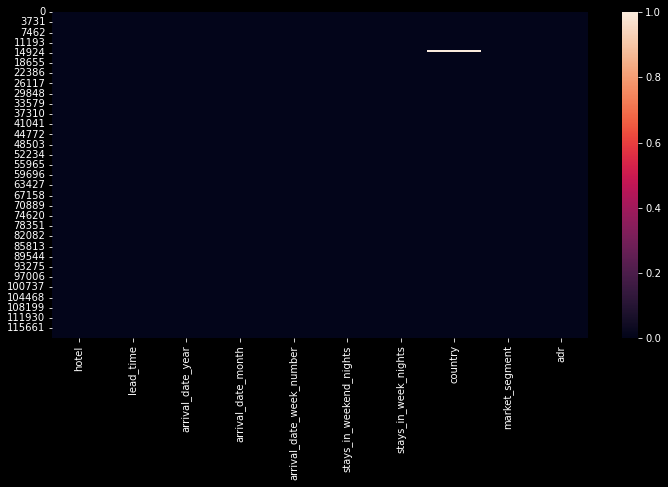

In [53]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull());

Observamos que algunas reservas no tienen informadas el país de origen, pero, como su número es insignificante, las eliminamos del conjunto de datos:

In [54]:
data = data.dropna()

## 3.1. Preprocesado de variables categóricas

La comprobación que hemos hecho no es suficiente para garantizar la ausencia de valores desconocidos. Estudiemos variable por variable en búsqueda de anomalías que nos sugieran que su valor es desconocido:

### **hotel**

In [55]:
list(data["hotel"].unique())

['Resort Hotel', 'City Hotel']

### **arrival_date_month**

In [56]:
sorted(data["arrival_date_month"].unique(), key = lambda m: datetime.strptime(m, "%B"))

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

### **country**

In [57]:
countries = set(data["country"].unique())
list(data["country"].unique()[0:5])

['PRT', 'GBR', 'USA', 'ESP', 'IRL']

In [58]:
len(data["country"].unique())

177

El conjunto de datos contiene reservas de 177 países. A continuación, vamos a comprobar que todos estos están en **formato ISO 3166-1 alpha-3**, como indica el autor del *dataset*. Para ello, obtenemos la lista de Wikipedia:

In [59]:
headers = {
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,\
    */*;q=0.8",
    "Accept-Encoding": "gzip, deflate, sdch, br",
    "Accept-Language": "en-US,en;q=0.8",
    "Cache-Control": "no-cache",
    "dnt": "1",
    "Pragma": "no-cache",
    "Upgrade-Insecure-Requests": "1",
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3) AppleWebKit/5\
    37.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36"
}

url = "https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes"

response = requests.get(url, stream=True, headers=headers)

soup = BS(response.content, 'html.parser')

fields = soup.select('a[title="ISO 3166-1 alpha-3"] span')

ISO = set()

for field in fields:
    code = field.text
    ISO.add(code)

Comprobamos que todos los códigos están contenidos en la lista que obtuvimos de Wikipedia:

In [60]:
(set(ISO) & set(countries)) == set(countries)

False

In [61]:
countries - ISO

{'CN', 'TMP'}

Por un lado, 'CN' hace referencia a China, pero está en el formato ISO 3166-1 alpha-2, por lo que lo transformamos a su equivalente, 'CHN', en formato alpha-3:

In [62]:
data.loc[data["country"] == "CN", "country"] = "CHN"

Por otro, desconocemos el país al que hace referencia 'TMP', por lo que procedemos a su eliminación del conjunto de datos, no sin antes comprobar que solo un % pequeño de observaciones hacen referencia a él:

In [63]:
(data.loc[data["country"] == "TMP", "country"].count()/len(data))*100

0.0025230862390876524

In [64]:
data = data.drop(data.loc[data["country"] == "TMP", "country"].index)

### **market_segment**

In [65]:
list(data["market_segment"].unique())

['Direct',
 'Corporate',
 'Online TA',
 'Offline TA/TO',
 'Complementary',
 'Groups',
 'Undefined',
 'Aviation']

La variable *market_segment* tampoco se libra de los valores nulos. Comprobamos que son una parte pequeña del conjunto de datos y los eliminamos:

In [66]:
(data.loc[data["market_segment"] == "Undefined", "market_segment"].count()/len(data))*100

0.0016820999335570527

In [67]:
data = data.drop(data.loc[data["market_segment"] == "Undefined", "market_segment"].index)

## 3.2. Preprocesado de variables numéricas

### **lead_time**

In [68]:
pd.DataFrame(data["lead_time"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
lead_time,118897.0,104.311101,106.904193,0.0,18.0,69.0,161.0,737.0


Parece raro que una reserva se haga con 737 días de antelación. Vamos a representar los valores en una caja de bigotes para identificar valores extremos:

C:\Users\engin\anaconda3\envs\practica2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


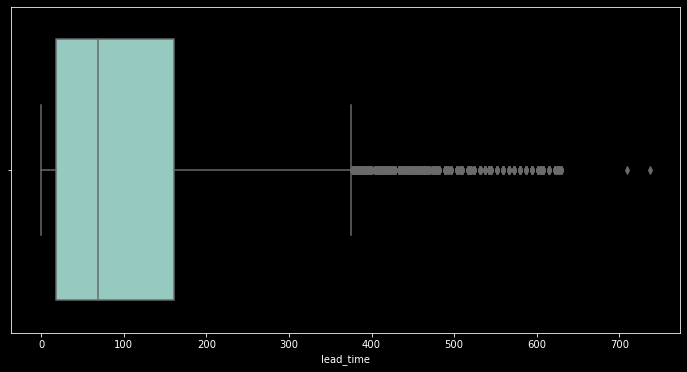

In [69]:
plt.figure(figsize=(12, 6))
plt.style.use('dark_background')

sns.boxplot(data['lead_time'])

plt.show()

Establecemos que aquellos valores que sean mayores que 1.5 veces el valor del rango intercuartil (IQR) son anómalos.

In [70]:
# ¿Cuál es el rango intercuartil de 'lead_time'?
Q1, Q3 = data['lead_time'].quantile([.25, .75])
# Rango intercuartil = Tercer cuartil - Primer cuartil
IQR = Q3 - Q1 
IQR

143.0

In [71]:
# ¿Cuántos valores anómalos tiene la variable 'lead_time'?
((data['lead_time'] < (Q1 - 1.5 * IQR)) | (data['lead_time'] > (Q3 + 1.5 * IQR))).sum()

2982

In [72]:
# ¿Cuál es el % de estos comparado con el total?
((data['lead_time'] < (Q1 - 1.5 * IQR)) | (data['lead_time'] > (Q3 + 1.5 * IQR))).sum()*100/len(data)

2.5080531888945896

### **arrival_date_year**

In [73]:
list(data["arrival_date_year"].unique())

[2015, 2016, 2017]

### **arrival_date_week_number**

In [74]:
pd.DataFrame(data["arrival_date_week_number"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
arrival_date_week_number,118897.0,27.166262,13.589722,1.0,16.0,28.0,38.0,53.0


In [75]:
len(data["arrival_date_week_number"].unique())

53

La muestra de reservas obtenida cubre todas las semanas del año.

In [76]:
data.dtypes["arrival_date_week_number"]

dtype('int64')

Los valores de la variable está contenida en el rango [1, 53] de los números naturales, como acabamos de comprobar.

### **stays_in_weekend_nights**

In [77]:
pd.DataFrame(data["stays_in_weekend_nights"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
stays_in_weekend_nights,118897.0,0.928888,0.996224,0.0,0.0,1.0,2.0,16.0


### **stays_in_week_nights**

In [78]:
pd.DataFrame(data["stays_in_week_nights"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
stays_in_week_nights,118897.0,2.502183,1.90018,0.0,1.0,2.0,3.0,41.0


In [79]:
#derivamos una columna nueva donde se calcula la estancia total
data["total_stay"] = data["stays_in_week_nights"] + data["stays_in_weekend_nights"]
data.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,country,market_segment,adr,total_stay
0,Resort Hotel,342,2015,July,27,0,0,PRT,Direct,0.0,0
1,Resort Hotel,737,2015,July,27,0,0,PRT,Direct,0.0,0
2,Resort Hotel,7,2015,July,27,0,1,GBR,Direct,75.0,1
3,Resort Hotel,13,2015,July,27,0,1,GBR,Corporate,75.0,1
4,Resort Hotel,14,2015,July,27,0,2,GBR,Online TA,98.0,2


In [80]:
#inspeccionamos si hay valores 0 en el total de la estancia, estos valores si considereran error y hay que tratarlas
len(data[data["total_stay"] == 0].index)

701

In [81]:
#para corregir estos registros vamos a hacer replace con el mean
data['total_stay']=data['total_stay'].replace(0,int(data['total_stay'].mean()))
data.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,country,market_segment,adr,total_stay
0,Resort Hotel,342,2015,July,27,0,0,PRT,Direct,0.0,3
1,Resort Hotel,737,2015,July,27,0,0,PRT,Direct,0.0,3
2,Resort Hotel,7,2015,July,27,0,1,GBR,Direct,75.0,1
3,Resort Hotel,13,2015,July,27,0,1,GBR,Corporate,75.0,1
4,Resort Hotel,14,2015,July,27,0,2,GBR,Online TA,98.0,2


C:\Users\engin\anaconda3\envs\practica2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total_stay'>

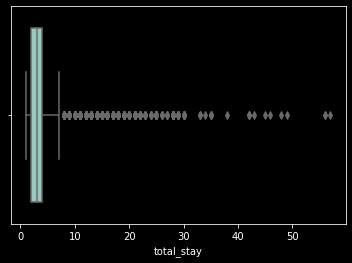

In [82]:
sns.boxplot(data['total_stay'])

In [83]:
data = data[data['total_stay'] < 10]

### **adr**

In [84]:
pd.DataFrame(data["adr"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
adr,115656.0,102.050373,50.389811,0.0,70.0,95.0,126.0,5400.0


C:\Users\engin\anaconda3\envs\practica2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='adr'>

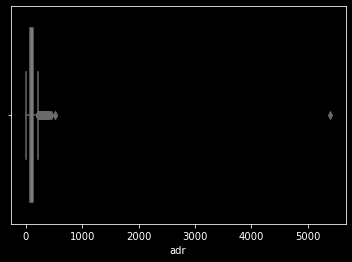

In [85]:
sns.boxplot(data['adr'])

In [86]:
#droping the outlier in adr and total stay column
data = data[data['adr'] < 200]

# 4. Análisis de los datos

1. Selección de los grupos de datos que se quieren analizar/comparar (planificación de los análisis a aplicar).
2. Comprobación de la normalidad y homogeneidad de la varianza.
3. Aplicación de pruebas estadísticas para comparar los grupos de datos. En función de los datos y el objetivo del estudio, aplicar pruebas de contraste de hipótesis, correlaciones, regresiones, etc. Aplicar al menos tres métodos de análisis diferentes.

We want to analyse which attributes of an hotel reservation to get cheap daily rates

How many days of total stay?
Which month of the year?
Which sales channel?

# 5. Visualización

Representación de los resultados a partir de tablas y gráficas.

<AxesSubplot:xlabel='total_stay', ylabel='adr'>

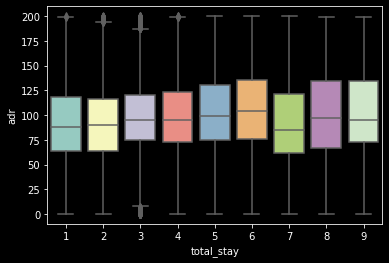

In [87]:
sns.boxplot(x = data['total_stay'] , y = data['adr'])

From the above graph we can see that when reserving for a total stay of 7 days we get the best daily rates

hotel,City Hotel,Resort Hotel
arrival_date_month,,
January,82.281448,49.824170
February,84.099920,55.581620
March,90.561816,57.813641
April,108.220492,77.785552
May,117.671626,78.344876
June,115.743435,108.426131
July,106.663735,135.663065
August,108.730344,149.930708
September,107.160057,92.428957


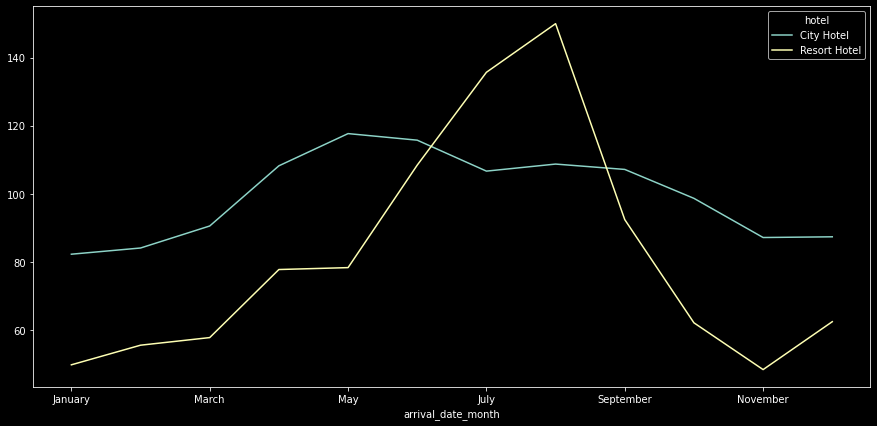

In [88]:
## Order of months
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
             'November', 'December']


sorted_month_average_rate = data.groupby(['arrival_date_month','hotel']).mean()['adr'].unstack().reindex(new_order)
## Draw the line plot
fig, ax = plt.subplots(figsize=(15,7))
sorted_month_average_rate.plot(ax=ax)
sorted_month_average_rate

From the above graph we can see that January has the lower daily rates in City hotel & November in Resorthotel

In [89]:
average_adr_per_country = data.groupby(['country']).mean()['adr'].sort_values(ascending=False)
average_adr_per_country

country
LAO    181.665
NCL    175.500
SLV    148.850
BHR    145.330
MMR    145.000
        ...   
COM     71.610
BHS     50.850
BDI     46.000
MDG     44.000
CYM     40.500
Name: adr, Length: 171, dtype: float64

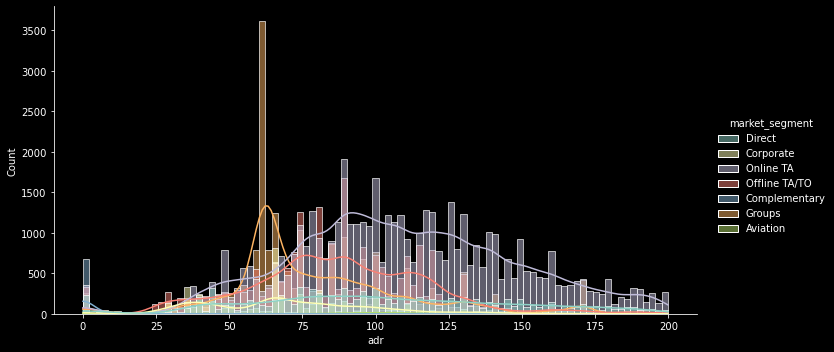

In [90]:
sns.displot(data, x="adr", hue="market_segment", kde=True, aspect = 2)


In [91]:
data.groupby(['market_segment']).describe()['adr']

,count,mean,std,min,25%,50%,75%,max
market_segment,,,,,,,,
Aviation,213.0,99.834178,22.815856,0.0,95.00,95.0,110.0,193.50
Complementary,731.0,2.933748,14.146941,0.0,0.00,0.0,0.0,170.00
Corporate,5021.0,70.134017,30.314423,0.0,45.00,66.0,89.0,197.10
Direct,10997.0,102.977674,44.371522,0.0,73.00,99.0,135.0,199.73
Groups,19493.0,78.754966,29.913563,0.0,62.00,70.0,95.0,192.25
Offline TA/TO,22745.0,86.580847,31.571321,0.0,68.40,86.0,108.0,199.75
Online TA,51590.0,109.240580,38.126110,0.0,82.88,107.1,135.0,199.86


Los datos estadisticos descriptivos (mean,std) de los diferentes market_segment y la representacion grafica muestra que los precios (adr) no sigue una distribucion normal, asi que vamos a utilizar un test de hipotesis no paramétrica como el test de Kruskal-Wallis para hacer los contrastes de hipótesis de más de 2 grupos

La hipótesis nula es que todas las canales donde se reserva habitaciones tiene el mismo precio diario promedio, 
asi que da igual donde reservas una habitacion,va a tener casi el mismo precio
La hipótesis alternativa de que los precios difieren de forma significativa

In [93]:
stats.kruskal(data['adr'][data['market_segment'] == 'Direct'],
               data['adr'][data['market_segment'] == 'Corporate'],
               data['adr'][data['market_segment'] == 'Online TA'],
               data['adr'][data['market_segment'] == 'Offline TA/TO'],
               data['adr'][data['market_segment'] == 'Complementary'],
               data['adr'][data['market_segment'] == 'Groups'],
               data['adr'][data['market_segment'] == 'Aviation'])

KruskalResult(statistic=17199.66398388308, pvalue=0.0)

# 6. Conclusiones

Resolución del problema. A partir de los resultados obtenidos, ¿cuáles son las conclusiones? ¿Los resultados permiten responder al problema?

El test de Kruskal-Wallis resulto un pvalue = 0 significa que los precios difieren de forma significativa entre un market_segment y otro